In [31]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import plotly.figure_factory as ff
import random

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [92]:

def generate_power_lognormal_array(size, mean_log=3.0, sigma_log=0.5, clip_range=(0, 100)):
    """
    Generate an array of random numbers from a power log-normal distribution.

    Parameters:
    - size: Size of the array.
    - mean_log: Mean of the natural logarithm of the distribution.
    - sigma_log: Standard deviation of the natural logarithm of the distribution.
    - clip_range: Tuple specifying the range to clip the values.

    Returns:
    - Array of random numbers.
    """
    random_numbers = np.random.lognormal(mean_log, sigma_log, size)
    clipped_numbers = np.clip(random_numbers, clip_range[0], clip_range[1])
    return clipped_numbers.astype(int)


def create_guassian():
    # Set the mean and standard deviation for the Gaussian distribution
    mean = 50  # Mean value
    std_dev = 25  # Standard deviation
    
    # Generate an array of 100 random Gaussian numbers
    random_gaussian_numbers = np.random.normal(loc=mean, scale=std_dev, size=100)
    random_gaussian_numbers = np.round(random_gaussian_numbers)
    # Clip the values to be within the range [0, 100]
    random_gaussian_numbers = np.clip(random_gaussian_numbers, 0, 100)
    random_gaussian_numbers = random_gaussian_numbers.astype(int)
    return random_gaussian_numbers

def generate_pareto_array(size, alpha=1.0, scale=4.0, clip_range=(0, 100)):
    """
    Generate an array of random numbers from a Pareto distribution.

    Parameters:
    - size: Size of the array.
    - alpha: Shape parameter of the distribution.
    - scale: Scale parameter of the distribution.
    - clip_range: Tuple specifying the range to clip the values.

    Returns:
    - Array of random numbers.
    """
    random_numbers = np.random.pareto(alpha, size) * scale
    clipped_numbers = np.clip(random_numbers, clip_range[0], clip_range[1])
    return clipped_numbers.astype(int)

In [108]:
np.random.seed(42)

# Create column names
locations = {
    'program1': ['site1', 'site2', 'site3', 'site4'],
    'program2': ['site1.1', 'site2.1', 'site3.1', 'site4.1', 'site5.1', 'site6.1', 'site7.1'],
    'program3': ['site1.2', 'site2.2', 'site3.2', 'site4.2', 'site5.2', 'site6.2', 'site7.2', 'site8.2', 'site9.2'],
    'program4': ['site1.3', 'site2.3', 'site3.3', 'site4.3', 'site5.3', 'site6.3', 'site7.3', 'site8.3',""]
}
years = list(range(2020, 2051))


# Create a DataFrame with random values
data = {
    'program1': np.random.choice(locations['program1'], size=100),
    'program2': np.random.choice(locations['program2'], size=100),  # Set size to 100 for program2
    'program3': np.random.choice(locations['program3'], size=100),  # Set size to 100 for program3
    'program4': np.random.choice(locations['program4'], size=100),  # Set size to 100 for program4
    **{f'Year_{year}': generate_pareto_array(size=100) for year in years}
}

first_df = pd.DataFrame(data)

# Sum horizontally across year columns and create a 'Total' column
first_df['Total'] = first_df.loc[:, [f'Year_{year}' for year in years]].sum(axis=1)


In [109]:
# Select columns that aren't years
subset_columns = ['program1', 'program2', 'program3', 'program4', 'Total']

# Create a new DataFrame with the selected columns
df = first_df.loc[:, subset_columns]

# Display the new DataFrame
df.head()

,program1,program2,program3,program4,Total
0,site3,site7.1,site4.2,,211
1,site4,site2.1,site7.2,site3.3,340
2,site1,site2.1,site3.2,site3.3,249
3,site3,site4.1,site6.2,site3.3,384
4,site3,site2.1,site2.2,site4.3,119


In [110]:
grouped_programs = df.groupby(["program1","program2","program3"]).sum()["Total"].reset_index()

In [111]:
grouped_programs.head()

,program1,program2,program3,Total
0,site1,site1.1,site1.2,406
1,site1,site1.1,site2.2,465
2,site1,site2.1,site2.2,486
3,site1,site2.1,site3.2,249
4,site1,site2.1,site8.2,360


In [112]:
site_df = {}
for program in grouped_programs["program1"].unique().tolist():
    sub_df = grouped_programs[grouped_programs["program1"] == program]
    sub_df["proportions"] = sub_df["Total"].apply(lambda x: x / sub_df["Total"].sum())
    sub_df = sub_df[["program2","program3","proportions"]]
    site_df[program]  = sub_df

In [113]:
# You can do this for each site

In [114]:
site1_df = site_df.get("site1")

In [115]:
categories = list(site1_df["program2"].unique())
sorted_categories = sorted(categories, key=str.lower)

In [116]:
site1_df["program2"] = pd.Categorical(
    site1_df["program2"], 
    categories=sorted_categories, 
    ordered=True
)

# Finally, sort the values in the data frame according to this custom sort.
site1_df = site1_df.sort_values("program2", ascending=False)

In [117]:
# Define colors
COLORS = ["#0C2C84", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)

In [118]:
def plot_heatmap(ax,df):
    # Iterate over types of plastic
    for i, prog3 in enumerate(df["program3"].unique().tolist()):
        # Select data for the given type of plastic
        d = df[df["program3"] == prog3]

        # Get values for the x and y axes
        y = d["program2"]
        x = [i] * len(y)
        
        # Generate colors. No need to normalize since proportions are between 0 and 1.
        color = cmap(d["proportions"]) 
        
        # Plot the markers for the selected company
        ax.scatter(x, y, color=color, s=120)

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(df["program3"].unique().tolist())))

    # Set labels for the x ticks (the names of the types of plastic)
    ax.set_xticklabels(df["program3"].unique().tolist())

    # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
    ax.tick_params(size=0, colors="0.3")

    # Set label for horizontal axis.
    ax.set_xlabel("Stuff", loc="right")

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)
    
    return ax

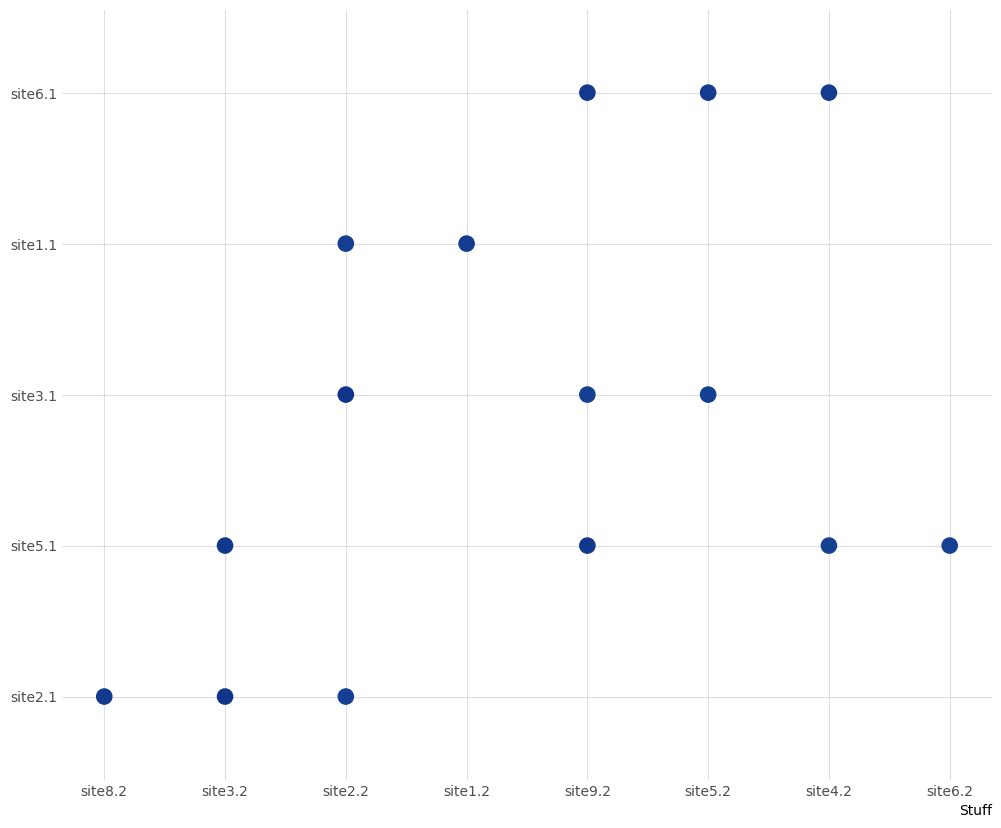

In [119]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_heatmap(ax,site1_df);

In [123]:
from functools import reduce

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from flexitext import flexitext
from scipy.special import expit

In [139]:
plasma_colormap = matplotlib.cm.get_cmap("plasma")

COLORS = [plasma_colormap(x) for x in np.linspace(0.8, 0.15, num=4)]
COLORS = [matplotlib.colors.to_hex(color) for color in COLORS]
COLORS

C:\Users\ajfon\AppData\Local\Temp\ipykernel_22136\1207226933.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma_colormap = matplotlib.cm.get_cmap("plasma")


['#fca636', '#de5f65', '#a62098', '#5601a4']

In [149]:
data_to_graph = first_df.groupby(["program1","program2"]).sum()[[f'Year_{year}' for year in years]].reset_index()

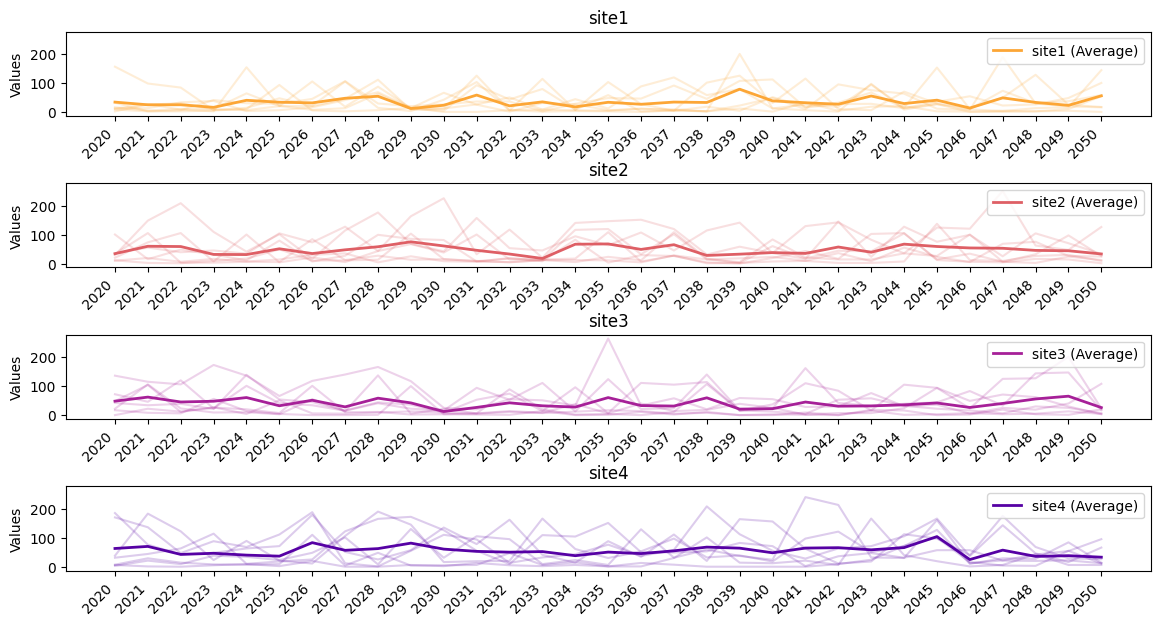

In [193]:
fig, axes = plt.subplots(4, 1, figsize=(14, 7), sharey=True)
plt.subplots_adjust(hspace=0.8) 
for i, (site, color) in enumerate(zip(data_to_graph["program1"].unique().tolist(),COLORS)):
    subdf = data_to_graph[data_to_graph["program1"] == site]
    subdf = subdf[subdf.columns.tolist()[1:]]
    subdf = subdf.set_index("program2")
    subdf = subdf.T
    avg_values = subdf.mean(axis=1)
    for col in subdf.columns:
        vals_to_plot = subdf[col].values
        index = [i for i in range(len(subdf.index.tolist()))]
        axes[i].plot(index, vals_to_plot, color=color, alpha=0.2, lw=1.5)
        axes[i].set_xticks(index)
        axes[i].set_xticklabels([y.strip("Year_") for y in subdf.index.tolist()], rotation=45, ha='right')  # Adjust rotation and alignment as needed
        axes[i].set_ylabel('Values')
        axes[i].set_title(f'{site}')

    axes[i].plot(avg_values, color=color, lw=2, label=f'{site} (Average)')
    axes[i].legend(loc='upper right')
    # Set x-axis labels and ticks
    axes[i].set_xticks(range(len(avg_values)))
    axes[i].set_xticklabels([y.strip("Year_") for y in subdf.index.tolist()], rotation=45, ha='right')

# Add legend
plt.legend(loc='upper right')


# Show the plot
plt.show()